In [1]:
%%html
<style>
p {
    max-width: 45em;
    word-wrap: break-word;
    }
li{
    max-width: 40em;
    word-wrap: break-word;
    margin:0 0 5px 0;
    }
.output {
    margin:0px 0px 0px 0px;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    margin:10px 0px 30px -30px;
    }
</style>

<br>
<p style="text-align:center; font-family: Arial; max-width: 65em">
    <font size=6>Automated Exploratory Data Analysis</font>
    <br>
    <br></p>

In [2]:
# Import packages and set package parameters
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import astropy
from astropy.stats import freedman_bin_width

# Print version number of packages
pyv = !python --version
pyv_str = str(pyv[0]).split()
print(f'{"PACKAGE":<20} VERSION')
print(f'{pyv_str[0]:<20} {pyv_str[1]}')
print('\n'.join(f'{m.__name__:<20} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

PACKAGE              VERSION
Python               3.8.5
numpy                1.19.2
pandas               1.1.3
matplotlib           3.3.2
seaborn              0.11.0
astropy              4.0.2


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Dataset-overview" data-toc-modified-id="1.-Dataset-overview-1">1. Dataset overview</a></span><ul class="toc-item"><li><span><a href="#1.1-Numerical-variables-distributions" data-toc-modified-id="1.1-Numerical-variables-distributions-1.1">1.1 Numerical variables distributions</a></span></li><li><span><a href="#1.2-Categorical-variables-distributions" data-toc-modified-id="1.2-Categorical-variables-distributions-1.2">1.2 Categorical variables distributions</a></span></li></ul></li><li><span><a href="#2.-Numerical-variables-relationships" data-toc-modified-id="2.-Numerical-variables-relationships-2">2. Numerical variables relationships</a></span></li><li><span><a href="#3.-Numerical-categorical-relationships" data-toc-modified-id="3.-Numerical-categorical-relationships-3">3. Numerical-categorical relationships</a></span></li><li><span><a href="#4.-Categorical-variables-relationships" data-toc-modified-id="4.-Categorical-variables-relationships-4">4. Categorical variables relationships</a></span></li><li><span><a href="#5.-Time-series" data-toc-modified-id="5.-Time-series-5">5. Time series</a></span></li></ul></div>

# 1. Dataset overview

In [3]:
# Import dataset from seaborn
df_raw = sns.load_dataset('penguins')
df_raw

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
df_raw.astype(str).describe()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,344,344,344,344,344
unique,3,3,165,81,56,95,3
top,Adelie,Biscoe,41.1,17.0,190.0,3800.0,Male
freq,152,168,7,12,22,12,168


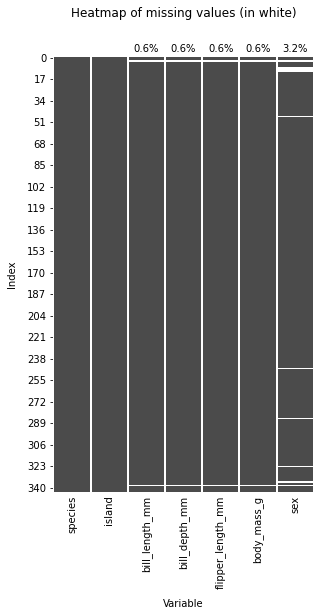

In [6]:
# Draw heatmap of missing values
# Design inspired by missingno package matrix figure
if df_raw.isnull().any().sum():
    # Draw seaborn heatmap
    nvar = df_raw.columns.size
    width = nvar/1.5 if nvar < 23 else 15
    ax1 = sns.heatmap(df_raw.notnull(), cmap='Greys', cbar=False, vmin=0, vmax=1.3)
    ax1.vlines(np.append(0, np.arange(nvar)+1), *ax1.get_ylim(), colors='white', linewidth=2)
    ax1.set_title('Heatmap of missing values (in white)', pad=40)
    ax1.set_xlabel('Variable', labelpad=10)
    ax1.set_ylabel('Index', labelpad=10)
    ax1.set_xticks(np.arange(nvar)+0.5)
    ax1.set_xticklabels(df_raw.columns, rotation=90)
    ax1.tick_params(axis='x', length=0)
    ax1.figure.set_size_inches(width, 8)
    
    # Compute proportion of missing values for each variable and display it
    # on top x axis
    nan_pc = df_raw.isnull().sum()/df_raw.index.size
    ax2 = ax1.twiny()
    ax2.set_xlim(0, nvar)
    ax2.set_xticks(np.linspace(0.5, nvar-0.5, nvar))
    ax2.set_xticklabels([f'{pct:.1%}' if pct>0 else '' for pct in nan_pc])
    ax2.xaxis.set_ticks_position('top')
    ax2.tick_params(axis='x', length=0)
    ax2.set_frame_on(False)

else:
    print('There are no missing data points in this dataset')

In [7]:
# Create copy of dataframe and set all variable names to lowercase
df = df_raw.copy()
df.columns = [var.lower() for var in df]

In [8]:
# Convert variable dtypes and remove variables if needed
for var in df:
    # Convert float to int if it contains only whole numbers and no nan
    # (avoid using Int64 due to plotting issues)
    if 'float' in str(df[var].dtype):
        if all(df[var]%1 == 0.0):
            df[var] = df[var].astype('int')
    # Convert category to object to classify it as a categorical variable
    if 'category' in str(df[var].dtype):
        df[var] = df[var].astype('object')
    # Convert binary variables of bool or any other data type to object
    # as dummy variables usually encode categorical features and this
    # makes seaborn pairplot work (bool dtype cannot be plotted in v0.10)
    if df[var].nunique() == 2:
        df[var] = df[var].astype('object')
    # Remove constants, variables containing only NaN and index variables
    if df[var].nunique() == 1 or df[var].isnull().all():
        df = df.drop(columns=var)
    elif (df[var] == df.index).all():
        if var == 'unnamed: 0':
            df.drop(columns=var, inplace=True)
        else:
            df.set_index(var, inplace=True)

In [9]:
# Identify and convert date variables that are not already of dtype
# datetime and stored in separate columns

date_names = ['date', 'year', 'quarter', 'month', 'day']

if 'date' not in df.select_dtypes('datetime').columns:
    columns = df.select_dtypes(exclude='datetime').columns
    if 'year' in columns and 'month' in columns and 'day' in columns:
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df.drop(columns=['year','month','day'])
    elif 'year' in columns and 'month' in columns and not 'day' in columns:
        df['year_month'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%b')
        df = df.drop(columns=['year','month'])
    elif 'year' in columns and not 'month' in columns and not 'day' in columns:
        df['year'] = pd.to_datetime(df['year'], format='%Y')

In [10]:
# List rows of mostly discrete float variable that exceptionnaly contain
# decimal values or nan to check whether they should be discarded or transformed
# df[(df['body_mass_g']%1) != 0.0]

In [11]:
# Additional manual change of dataframe as needed
# df = df.drop(columns=[''])
# df = df.drop_duplicates(keep='first')

In [12]:
# Reprint dataframe info if any modifications have been made to the number
# of variables or the data types
cond1 = df.columns.size == df_raw.columns.size
cond2 = all([str(df.iloc[:,i].dtype) == str(df_raw.iloc[:,i].dtype) for i in range(df.columns.size)])
if cond1 and cond2:
    None
else:
    print('Variables selected for the EDA with data types corrected as needed:\n')
    df.info()

In [13]:
def var_types(df):
    """
    Print the scale of measurement of each variable contained in the
    dataframe.
    
    Parameter
    ---------
    df: pandas DataFrame
    """
    col_width = 20
    print(f'{"VARIABLE":<{col_width}} TYPE')
    for var in df.columns:
        var_str = f'{var:<{col_width}}'
        
        # Check if is binary
        if df[var].nunique() == 2:
            print(f'{var_str} binary')
        
        # Check if is categorical (other than binary)
        elif df[var].dtype == 'object':
            print(f'{var_str} categorical')
        
        # Check if is numerical of type float
        elif 'float' in str(df[var].dtype):
            if all(df[var].dropna()%1 == 0.0):
                print(f'{var_str} numerical discrete (integers only)')
            else:
                print(f'{var_str} numerical continuous')
        
        # Check if is numerical of type integer
        elif 'int' in str(df[var].dtype):
            print(f'{var_str} numerical discrete (integers only)')
            
        # Check if is datetime
        elif 'datetime' in str(df[var].dtype):
            print(f'{var_str} datetime')
        
        else:
            print(f'{var_str} variable type not recognised')

In [14]:
var_types(df)

VARIABLE             TYPE
species              categorical
island               categorical
bill_length_mm       numerical continuous
bill_depth_mm        numerical continuous
flipper_length_mm    numerical discrete (integers only)
body_mass_g          numerical discrete (integers only)
sex                  binary


In [15]:
"""
Set the limit of unique values that will serve to select the categorical
and numerical discrete variables to display in plots in the rest of the
notebook.

This serves to solve two issues regarding plotting depending on the type
of variable:
1. Categorical variables such as names of locations or of individuals
may have many (or even exclusively) unique values which would be
uninteresting or impossible to visualize in plots;
2. There may be numerical discrete variables in the dataset which can be
plotted both as numerical and as categorical variables, especially if
they have only a few unique values. These can be identified with the
histograms plotted above.

At this point it may be useful to create transformed variables by
binning them so that they can be visualized. This is most relevant for
categorical variables as interesting size-dependent features of
numerical variables should become apparent in the boxplots further
below.
"""

# Select limit according to categorical variables and discrete numerical
# variables identified with the histograms
nb_unique_limit = 8
print('Maximum number of unique values for plotting categorical/discrete variables:', nb_unique_limit, '\n')



Maximum number of unique values for plotting categorical/discrete variables: 8 



In [16]:
# Create and print groups of variables based on data type and type of EDA plots
print('OVERVIEW OF VARIABLES GROUPED ACCORDING TO PLOTS\n')

# Create index of categorical and numerical discrete variables with
# few enough unique values for EDA visualizations
var_viz = df[[var for var in df if df[var].nunique() <= nb_unique_limit]].columns

# Create index of numerical variables to plot in histograms
var_num = df.select_dtypes('number').columns
cond_str = f'{"s" if var_num.size > 1 else ""}'
print(f'Histogram{cond_str}\n',
      var_num.values, '\n')

# Create index of numerical variables to plot in relationship plots
var_num_rel = var_num.drop(labels=df[var_viz].select_dtypes('number'))
cond_str = f'{"s" if var_num_rel.size > 1 else ""}'
print(f'Scatter plot{cond_str}\n',
      var_num_rel.values, '\n')

# Create index of numerical variables with few enough unique values to be
# assimilated to categorical variables
var_viz_num = df[var_viz].select_dtypes('number').columns
cond_str = f'{"s" if var_viz_num.size > 1 else ""}'
print(f'''Numerical discrete variable{cond_str} to visualize like categorical variables\n''',
      var_viz_num.values, '\n')

# Create index of categorical variables with few enough unique values
# for EDA visualizations
var_viz_cat = df[var_viz].select_dtypes(exclude='number').columns
cond_str = f'{"s" if var_viz_cat.size > 1 else ""}'
print(f'''Bar chart{cond_str} and hue in scatter plots\n''',
      var_viz_cat.values, '\n')

# Create index of categorical variables with too many unique values to be plotted
var_cat_extra = df.drop(columns=var_viz).select_dtypes('object').columns
cond_str = f'{"s" if var_cat_extra.size > 1 else ""}'
print(f'Categorical variable{cond_str} with too many unique values to be plotted\n',
      var_cat_extra.values, '\n')

# Print datetime variable
print('Datetime variable to use as index for time series\n',
      df.select_dtypes('datetime').columns.values if 'datetime' not in str(type(df.index)) else 'Dataframe index')

OVERVIEW OF VARIABLES GROUPED ACCORDING TO PLOTS

Histograms
 ['bill_length_mm' 'bill_depth_mm' 'flipper_length_mm' 'body_mass_g'] 

Scatter plots
 ['bill_length_mm' 'bill_depth_mm' 'flipper_length_mm' 'body_mass_g'] 

Numerical discrete variable to visualize like categorical variables
 [] 

Bar charts and hue in scatter plots
 ['species' 'island' 'sex'] 

Categorical variable with too many unique values to be plotted
 [] 

Datetime variable to use as index for time series
 []


## 1.1 Numerical variables distributions

In [17]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.00,342.00,342.00,342.00
mean,43.92,17.15,200.92,4201.75
std,5.46,1.97,14.06,801.95
min,32.10,13.10,172.00,2700.00
25%,39.23,15.60,190.00,3550.00
50%,44.45,17.30,197.00,4050.00
75%,48.50,18.70,213.00,4750.00
max,59.60,21.50,231.00,6300.00


In [18]:
# Create histogram function that makes bins more readable
def hist_align_bins(var, bin_width, nunique_lim=20, range_lim=30):
    """
    Create a histogram with bins of a selected width and overlaid with
    a kernel density estimator.
    
    A list of bins for the histogram 'bins' argument is created based on
    the range of the variable scores and on the selected width of bins.
    The bins are automatically aligned with round units making the
    histogram more readable.
    
    Parameters
    ----------
    var: pandas Series with dtype integer or float
        Numerical variable to plot in histogram.
    bin_width: integer, float
        Width of histogram bins in the units of the variable. This
        argument may be overriden depending on the nunique_lim setting.
    nunique_lim: integer
        Maximum number of unique values of the variable that determines
        whether or not to override the bin width and set it to 1 to plot
        discrete (integer) variables without binning the data.
    range_lim: integer
        Maximum range of the variable that determines whether or not to
        override the bin width and set it to 1 to plot discrete
        (integer) variables without binning the data. Also determines
        label formatting.
    """
    
    ## If variable dtype is float but it contains only whole numbers:
    ## drop nan and convert dtype to int64
    if 'int' not in str(var.dtype):
        if all(var.dropna()%1 == 0.0):
            var = var.dropna().astype(int)
        
    ## Override the bin width argument to set it to 1 automatically depending
    ## on dtype, number of unique values and range of values
    var_range = var.max()-var.min()
    if 'int' in str(var.dtype) and var.nunique() <= nunique_lim and var_range <= range_lim:
        bin_width = 1
    
    ## Compute list of bins based on the type of variable and range of values
    # List of bins for integer variables with bin_width = 1
    if 'int' in str(var.dtype) and bin_width == 1:
        leftmost_bin_edge = var.min() - 0.5
        rightmost_bin_edge = var.max() + bin_width + 0.5
        bins_list = np.arange(leftmost_bin_edge, rightmost_bin_edge)
    # List of bins for all other cases using 'while' loop to reduce number of bins
    # when freedman_bin_widths returns small bin width because of skewed distribution
    else:
        bins_list = []
        while len(bins_list) == 0 or len(bins_list) > 30:
            leftmost_bin_edge = var.min() - var.min()%bin_width
            rightmost_bin_edge = var.max() - var.max()%bin_width + 2*bin_width
            bins_list = np.arange(leftmost_bin_edge, rightmost_bin_edge, bin_width)
            bin_width *= 2
    
    ## Draw histogram depending on data type and bin size
    # Draw pandas histogram if variable is discrete (of type int) with bin_width = 1
    if 'int' in str(var.dtype) and bin_width == 1:
        ax = var.plot.hist(bins=bins_list, linewidth=0.5, edgecolor='white', alpha=0.9)
        if var_range < range_lim:
            ax.set_xticks(bins_list[:-1]+0.5)
        ax.tick_params(axis='x', rotation=0, length=0, pad=5)
        ax.set_xlabel(var.name, labelpad=10)
    # Else draw seaborn histogram with kde
    else:
        ax = sns.histplot(data=var, bins=bins_list, kde=True, alpha= 0.9,
                          edgecolor='white', linewidth=0.5,
                          line_kws=dict(color='black', alpha=0.5, linewidth=1.5,
                          label='kernel density estimator'))
        ax.set_xlabel(f'{var.name} (bins are left inclusive)', labelpad=10)
        ax.get_lines()[0].set_color('black') # manually edit line color due to bug with line_kws
        ax.legend(frameon=False, fontsize=9)
    
    # Additional formatting
    ax.figure.set_size_inches(7,4)
    ax.locator_params(axis='y', integer=True)
    ax.set_ylabel('Count', labelpad=10)
    ax.set_title(f'Distribution of {var.name}', pad=20)
    sns.despine()
    
    return ax

In [19]:
# Create list of bin widths using astropy function based on the
# Freedman-Diaconis rule (not well adapted to highly skewed data)
# https://docs.astropy.org/en/stable/api/astropy.stats.freedman_bin_width.html
freedman_bin_widths = [(var, freedman_bin_width(df[var].dropna())) for var in var_num]

# Round the freedman bin widths to more readable values
round_bin_widths = [1, 2.5, 5, 10]
bin_widths = []
nunique_lim = 20
range_lim = 30

for var, bin_width in freedman_bin_widths:
    # Set bin width to 1 automatically depending on dtype, number of
    # unique values and range of values
    var_range = df[var].max()-df[var].min()
    if 'int' in str(df[var].dtype) and df[var].nunique() <= nunique_lim and var_range <= range_lim:
        bin_widths.append(1)
    else:
        # Extract significant digits of the bin width expressed in
        # scientific notation
        bin_width_sci = np.format_float_scientific(bin_width)
        idx = str(bin_width_sci).find('e')
        sig_dig = float(bin_width_sci[:idx])
        # Extract exponent of the bin width expressed in scientific notation
        exponent = int(np.format_float_scientific(bin_width)[-3:])
        # Assign nearest round bin width value from list to bin width
        # expressed in scientific notation
        round_bin_width = min(round_bin_widths, key=lambda x:abs(x-sig_dig))
        bin_widths.append(round_bin_width*10**exponent)
    

cond_str = f'{"s" if var_num.size > 1 else ""}'
print(f'Automatically selected histogram bin width{cond_str}\n')
col_width = 20
print(f'{"VARIABLE":<{col_width}} BIN WIDTH')
print('\n'.join(f'{var:<{col_width}} {bin:>9}' for var, bin in zip(var_num, bin_widths)))

Automatically selected histogram bin widths

VARIABLE             BIN WIDTH
bill_length_mm             2.5
bill_depth_mm              1.0
flipper_length_mm            5
body_mass_g              250.0


In [20]:
# # Manually select more appropriate bin widths
# bin_widths = [2.5, 1, 1.0, 2.5, 2.5, 100, 25.0]
# cond_str = f'{"s" if var_num.size > 1 else ""}'
# print(f'Manually selected bin width{cond_str}:')
# print('\n'.join(f'{var:<15} {bin:>10}' for var, bin in zip(var_num, bin_widths)))

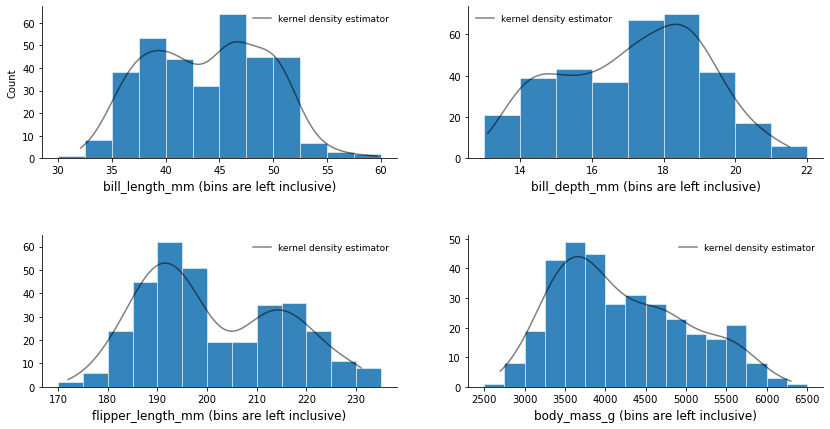

In [21]:
# Create grid of histograms using hist_align_bins function: the plot title
# is removed, the figure size is overriden if there is more than one
# variable to plot, and the ylabels and kde legends are removed to avoid
# redundancy

ncharts = var_num.size
ncols_max = 2
ncols = ncharts if ncharts < ncols_max else ncols_max
nrows = int(np.ceil(ncharts/ncols))
width = 7 if ncols <= 2 else 15/ncols
height = 0.5*width

fig = plt.figure()
for i, var in enumerate(var_num):
    ax = fig.add_subplot(nrows, ncols, i+1)
    hist_align_bins(var=df[var], bin_width=bin_widths[i])
    ax.set_title('')
    ax.set_ylabel('Count', labelpad=5) if i == 0 else ax.set_ylabel('')
    ax.set_xlabel(ax.get_xlabel(), size=12, labelpad=5)
    
fig.set_size_inches((ncols*width, nrows*height)) if ncharts > 1 else None
fig.subplots_adjust(hspace=0.5, wspace=0.2)

## 1.2 Categorical variables distributions

In [22]:
# Display descriptive statistics of the categorical/discrete variables
# selected for the visualizations in the rest of the notebook
if var_viz.size > 0:
    cond_str = f'{"s" if var_viz.size > 1 else ""}'
    print(f'''
Description of categorical/numerical discrete variable{cond_str} with few enough
unique values to be visualized''')
df[var_viz].astype('object').describe() if var_viz.size > 0 else None


Description of categorical/numerical discrete variables with few enough
unique values to be visualized


,species,island,sex
count,344,344,333
unique,3,3,2
top,Adelie,Biscoe,Male
freq,152,168,168


In [23]:
def bargrid(df, nb_unique_limit):
    """
    Create a bar chart for each categorical/numerical discrete
    variable in the dataset containing a number of unique values 
    less or equal to the selected limit.
    
    Parameters
    ----------
    df: pandas DataFrame
        DataFrame containing categorical and/or numerical discrete
        variables.
    nb_unique_limit: integer
        Number of unique values used as a cut-off to ensure chart
        readability.
    """
    
    ## Create list of names variables to plot
    var_cat = np.array([var for var in df if df[var].nunique() <= nb_unique_limit])
    
    ## Print statement for cases where this figure is not relevant
    if var_cat.size == 0:
        print(
'''There are no categorical and/or numerical discrete
variables in this dataset containing the cut-off number of
unique values or less, so bar charts are not relevant.
        ''')
    
    ## Create grid of bar charts
    else:
        # Set parameters for figure dimensions
        ncols_max = 5
        ncols = var_cat.size if var_cat.size < ncols_max else ncols_max
        nrows = int(np.ceil(var_cat.size/ncols))
        subp_w = 3 if ncols <= 3 else 15/ncols
        subp_h = 1.25*subp_w

        # Generate figure with appropriate dimensions and spacing between subplots
        fig = plt.figure(figsize=(ncols*subp_w, nrows*subp_h))
        fig.subplots_adjust(hspace=0.3, wspace=0.4)

        # Draw pandas bar charts side-by-side
        cmap = plt.cm.tab10.colors
        for idx, var in enumerate(var_cat):
            ax = fig.add_subplot(nrows, ncols, idx+1)
            counts = df[var].value_counts().sort_index()
            counts.plot.bar(width=0.5, color=cmap[idx%len(cmap)], title=var, ax=ax)
            ax.set_ylabel('count', labelpad=10) if (idx/ncols)%1 == 0 else None
            ax.locator_params(axis='y', integer=True)
            ax.tick_params(axis='x', rotation=0, length=0, pad=5)
        sns.despine()

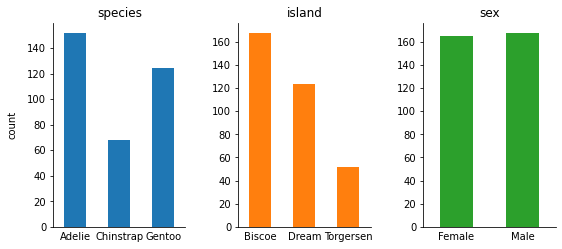

In [24]:
bargrid(df, nb_unique_limit)

# 2. Numerical variables relationships

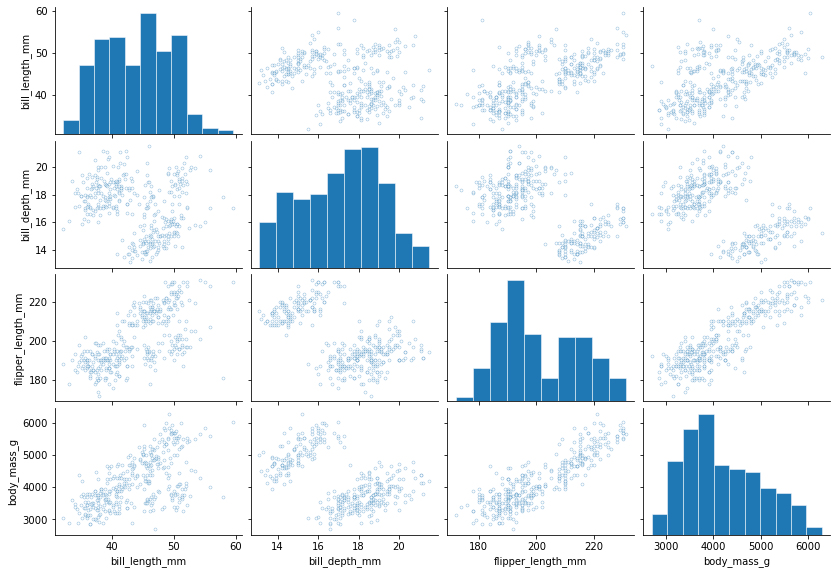

In [25]:
# Draw seaborn pairplot depending on number of numerical variables

var_num_rel_lim = 8  # maximum number of variables to plot automatically

if var_num_rel.size == 0:
    print(
'''There are no numerical variables with a large enough number of unique
values in this dataset, so a pairplot is not relevant.
    ''')
elif var_num_rel.size == 1:
    print(
'''There is only one numerical variable in this dataset, so a pairplot
is not relevant and the histogram of the diagonal plot is not shown.
    ''')
else:
    if var_num_rel.size > var_num_rel_lim:
        var_num_rel_plot = var_num_rel[:var_num_rel_lim]
        print(
f'''WARNING: There are {var_num_rel.size} numerical variables to plot,
only the first {var_num_rel_lim} are plotted.
        ''')
    else:
        var_num_rel_plot = var_num_rel
    g = sns.PairGrid(df[var_num_rel_plot], diag_sharey=False)
    g.map_offdiag(sns.scatterplot, marker='.', color='white',
                  edgecolor='tab:blue', alpha=0.5)
    g.map_diag(sns.histplot, edgecolor='white', linewidth=0.5, alpha=1)
    g.fig.set_size_inches(12,8)
    g.fig.subplots_adjust(hspace=0.05, wspace=0.05);

In [26]:
# Select variables to use as hue in pairplot
var_hue = var_viz
var_hue_lim = 10  # max nb of pairplots to generate automatically
if var_hue.size > 0 and var_num_rel.size >= 1:
    if var_hue.size <= var_hue_lim:
        var_hue_plot = var_hue
        cond_str = f'{"s" if var_hue_plot.size > 1 else ""}'
        print(f'Variable{cond_str} to plot as hue in scatterplot matrix\n',
              var_hue_plot.values)
    else:
        var_hue_plot = var_hue[:var_hue_lim]
        print(f'''WARNING: There are more than {var_hue_lim} variables to plot as hue in a scatterplot matrix,
only the following variables will be plotted:\n''',
              var_hue_plot.values)

Variables to plot as hue in scatterplot matrix
 ['species' 'island' 'sex']


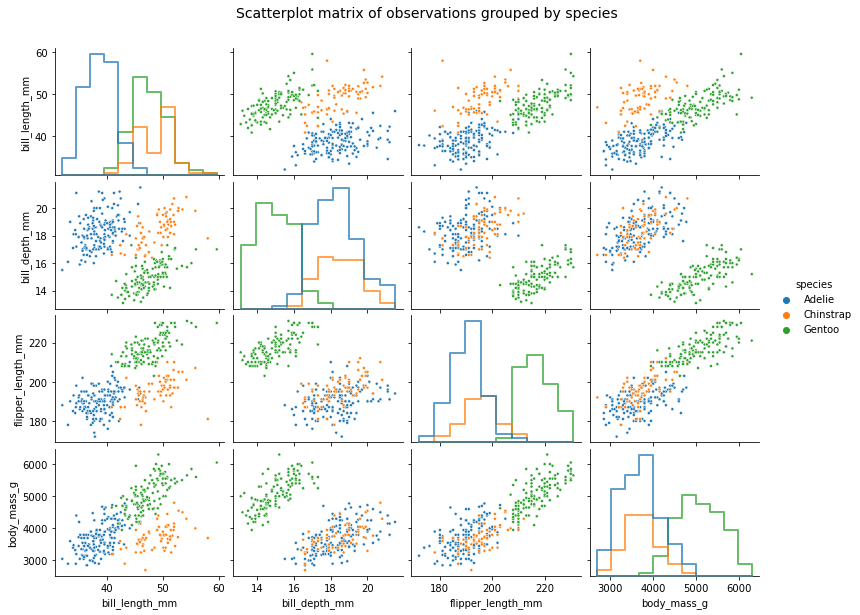

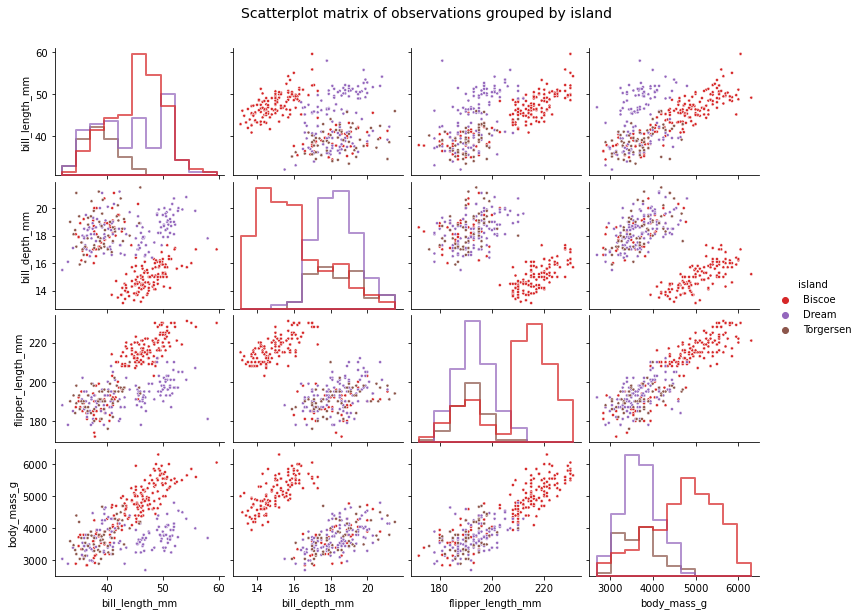

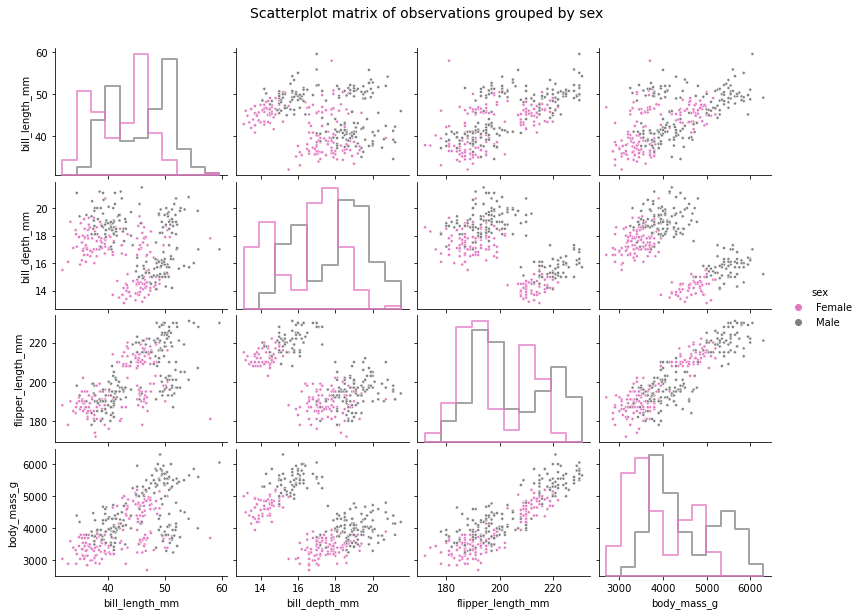

In [27]:
# Draw pairplot(s) with hue

var_num_rel_lim = 6
row_lim = 10000

if var_num_rel.size == 0:
    print(
'''There are no numerical variables with a large enough number of unique
values in this dataset, so a pairplot with hue is not relevant.
    ''')
elif var_hue.size == 0:
    print(
'''There are no categorical and/or numerical discrete variables
in this dataset containing the cut-off number of unique values
or less, so pairplots with hue variables are not relevant.
    ''')
else:
    if df.index.size > row_lim:
        print(f'''WARNING: The dataset contains more than {row_lim} rows,
assess if plotting by hue is worth the wait.''')
    elif var_num_rel.size > var_num_rel_lim:
        print(f'''WARNING: There are more than {var_num_rel_lim} numerical variables to plot,
assess if plotting by hue is worth the wait.''')
    else:
        # Set figure dimensions depending on number of numerical variables
        figsize = [8,4] if var_num_rel.size == 1 else [12,8]

        # Draw seaborn pairplots each with unique colors and with a workaround
        # to set the step histogram edgecolors
        cmap = plt.cm.tab10.colors
        color_list = cmap*int((df[var_viz_cat].nunique().sum()//len(cmap)+1))
        cmaps_seq = ['Oranges', 'Greens',  'Blues', 'Reds', 'Purples',
                     'BuGn', 'GnBu', 'OrRd', 'BuPu', 'PuBu', 'PuRd',
                     'YlGn', 'RdPu', 'YlGnBu', 'YlOrRd','PuBuGn', 'YlOrBr']
        for var in var_hue_plot:
            # Select colors depending on whether var is nominal or numeric
            if var in var_viz_cat:
                # Select colors from color_list
                idx = var_viz_cat.get_loc(var)
                color_i = int(df[var_viz_cat[:idx]].nunique().sum())
                colors = color_list[color_i:color_i+df[var].nunique()]
            else:
                # Select colors from sequential cmap starting with color that is not too light
                cmap = plt.get_cmap(cmaps_seq[var_viz_num.get_loc(var)])
                colors = cmap(np.linspace(0.3, 1, df[var].nunique())).tolist()
            data = df.drop(columns=var_viz).assign(hue=df[var]).sort_values('hue')
            g = sns.PairGrid(data, hue='hue', diag_sharey=False, palette=colors)
            g.map_offdiag(sns.scatterplot, marker='.')
            g.map_diag(sns.histplot, element="step", lw=2, alpha=0.0)
            for ax in g.diag_axes:
                for coll in ax.collections:
                    color, = coll.get_facecolor()
                    coll.set_edgecolor(np.append(color[:-1], 0.7))
            cond_str = (f'Histogram grouped by {var}' if var_num_rel.size == 1
                        else f'Scatterplot matrix of observations grouped by {var}')
            g.fig.suptitle(cond_str, y=1.05, fontsize=14)
            g.add_legend(title=var)
            g.fig.set_size_inches(figsize[0], figsize[1])
            g.fig.subplots_adjust(hspace=0.05, wspace=0.05);

# 3. Numerical-categorical relationships

In [28]:
def boxplotmatrix(df, nb_unique_limit):
    """
    Create a matrix of side-by-side boxplots with categorical and
    numerical discrete variables on the x axis and numerical continuous
    variables on the y axis.
    
    Parameters
    ----------
    df: pandas DataFrame
        DataFrame containing numerical continuous and categorical and/or
        numerical discrete variables.
    nb_unique_limit: integer
        Number of unique values used as a cut-off to ensure chart
        readability.
    """

    ### Create lists of names of variables to plot
    var_num = [var for var in df.select_dtypes('number')
               if df[var].nunique() > nb_unique_limit]
    var_cat = [var for var in df
               if df[var].nunique() <= nb_unique_limit]
    
    ncat = len(var_cat)
    
    ### Print statement for cases where this figure is not relevant
    if len(var_num) == 0:
        print(
'''There are no numerical variables with a large enough number of
unique values in this dataset, so boxplots are not relevant.
        ''')
    elif ncat == 0:
        print(
'''There are no categorical and/or numerical discrete
variables in this dataset containing the cut-off number of
unique values or less, so boxplots are not relevant.
        ''')
    
    ### Create boxplotmatrix
    else:
        def labels_nobs(var_n, var_c):
            """
            Add labels showing the number of observations contained in each boxplot.
            """
            ylim_max = df[var_n].max()+(0.1*(df[var_n].max()-df[var_n].min()))
            ax.set_ylim(ymax=ylim_max)
            nobs = df.groupby(var_c)[var_n].count().values
            for x_position, nobs in enumerate(nobs):
                ax.text(x=x_position, y=ylim_max, s=f'{nobs}', size=9,
                        verticalalignment='top', horizontalalignment='center')
        
        ## Define figure and axes parameters
        ncols_max = 5
        if ncat <= ncols_max:
            ncols = ncat
            nrows = len(var_num)
        else:
            ncols = ncols_max
            nrows = int(np.ceil(ncat/ncols))
        subp_w = 2.5 if ncols <= 4 else 12/ncols
        subp_h = 1.5*subp_w
        
        ## If the boxplots of each numerical variable can fit on a single
        ## line, create a single figure with one numerical variable per line
        if ncat <= ncols_max:
            g = sns.PairGrid(df, x_vars=var_cat, y_vars=var_num)
            g.map(sns.boxplot, whis=(5, 95), fliersize=1, linewidth=1,
                  width=0.3, saturation=1)
            g.fig.set_size_inches(ncols*subp_w, nrows*subp_h)
            
            # Format ticks, colors and add labels with number of observations
            colormap = plt.cm.tab10.colors
            for idx, ax in enumerate(g.axes.flat):
                var_n = var_num[int(idx/len(var_cat))]
                var_c = var_cat[idx%len(var_cat)]
                ax.tick_params(axis='x', length=0, pad=5)
                for child in ax.get_children():
                    if 'PathPatch' in str(child):
                        child.set_facecolor(colormap[idx%len(var_cat)%len(colormap)])
                labels_nobs(var_n, var_c)
        
        ## Else display each numerical variable in a separate figure with
        ## multiple lines of boxplots
        else:
            for var_n in var_num:
                data = df[[var_n, *var_cat]].melt(id_vars=var_n)
                # Sort data by converting 'variable' to Category type to ensure correct
                # order of boxplot levels like it is the default with PairGrid above
                data['variable'] = pd.Categorical(data['variable'], var_cat)
                data_sorted = data.sort_values(['variable', 'value'])
                g = sns.catplot(kind='box', data=data_sorted, x='value', y=var_n,
                                hue='variable', col='variable', col_wrap=ncols,
                                sharex=False, dodge=False, whis=(5, 95), fliersize=1,
                                linewidth=1, width=0.3, palette='tab10', saturation=1)
                g.fig.subplots_adjust(hspace=0.25, wspace=0.2)
                g.fig.set_size_inches(ncols*subp_w, nrows*subp_h)
                g.set_titles('')
                
                # Format ticks, x labels and add labels with number of observations
                for idx, ax in enumerate(g.axes.flat):
                    var_c = var_cat[idx]
                    ax.tick_params(axis='x', length=0, pad=5)
                    ax.set_xlabel(var_c, labelpad=5)
                    labels_nobs(var_n, var_c)

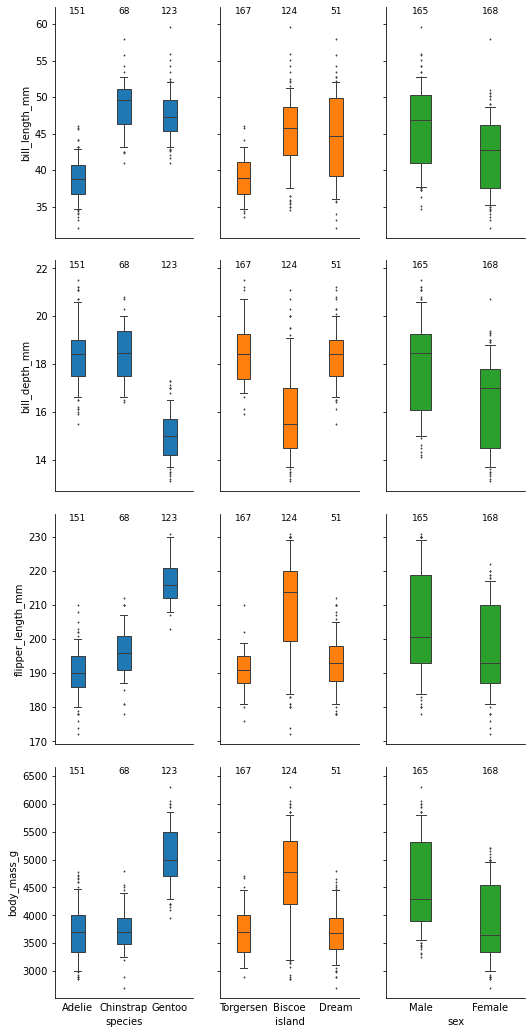

In [29]:
boxplotmatrix(df, nb_unique_limit)

# 4. Categorical variables relationships

In [30]:
def stackedbarmatrix(df, nb_unique_limit):
    """
    Create a matrix of percent stacked bar charts to display all
    relationships between categorical/numerical discrete variables in
    the dataset containing a number of unique values less or equal to
    the selected limit.
    
    Parameters
    ----------
    df: pandas DataFrame
        DataFrame containing categorical and/or numerical discrete
        variables.
    nb_unique_limit: integer
        Number of unique values used as a cut-off to ensure chart
        readability.
    """
    
    ### Create list of names of variables to plot
    var_cat = [var for var in df if df[var].nunique() <= nb_unique_limit]
    
    ### Define redundant figure parameters to improve code readability
    ncat, ncols, nrows = 3*(len(var_cat),)
    
    ### Print statement for cases where this figure is not relevant
    if ncat <= 1:
        cond_str1 = f'{"are no" if ncat == 0 else "is only one"}'
        cond_str2 = f'{"s"      if ncat == 0 else ""}'
        print(
f'''There {cond_str1} categorical and/or numerical discrete variable{cond_str2}
in this dataset containing the cut-off number of unique values or
less, so a matrix of stacked bar charts is not relevant.
        ''')
    
    ### Else create matrix of normalized stacked bar charts
    else:
        ## Create figure with required dimensions to fit all subplots
        width = {ncols==2: 4, ncols==3: 3, 4<=ncols<=6: 12/ncols, 6<ncols: 12/ncols}[True]
        height = 0.75*width
        ncat_size_lim = 6  # nb variables above which format will be adjusted for readability
        cmap = plt.cm.tab10.colors
        color_list = cmap*(df[var_cat].nunique().sum()//len(cmap)+1)
        
        ## Create function for offdiag plots; diag plots are added after grid generation
        def offdiag_plot(x, y, **kwargs):
            color_i = int(df[var_cat[:var_cat.index(x.name)]].nunique().sum())
            colors = color_list[color_i:color_i+df[x.name].nunique()]
            ax = plt.gca()
            data = pd.crosstab(y, x, normalize='index').sort_index(level=y, ascending=False)
            data.plot.barh(stacked=True, color=colors, legend=False, ax=ax)
            ax.set_ylabel(x.name, labelpad=10)
            ax.tick_params(axis='y', which='both', length=0)
            if ax.is_last_row() and not ax.is_last_col():
                ax.set_xlabel(x.name, labelpad=5)
                ax.xaxis.set_major_formatter('{x:.0%}')
            # Reduce tick label size when many subplots
            if ncat > ncat_size_lim:
                ax.tick_params(axis='x', which='both', labelsize=8, length=2)
                ax.tick_params(axis='y', which='both', labelsize=8, length=0)
        
        ## Generate seaborn grid, note that x_vars and y_vars kwargs are necessary
        ## here contrary to pairplot as it seems that seaborn does not recognize
        ## categorical variables automatically as plottable objects
        g = sns.PairGrid(df[var_cat], x_vars=var_cat, y_vars=var_cat)
        g.map_offdiag(offdiag_plot, label='')
        g.fig.set_size_inches(ncols*width, nrows*height)
        g.fig.subplots_adjust(hspace=0.2, wspace=0.15)
        
        ## Create bar charts in diagonal by first removing existing Axes and adding
        ## new one to solve issue of forced shared x-axis in PairGrid; plot with pandas
        ## to have custom bar width
        for idx, var in enumerate(var_cat):
            idiag = idx*ncols+idx
            g.axes.flat[idiag].remove()
            ax = g.fig.add_subplot(nrows, ncols, idiag+1)
            counts = df[var].value_counts().sort_index(ascending=False)
            counts.plot.barh(width=0.5, color='lightgrey', zorder=2, ax=ax)
            ax.tick_params(axis='both', which='both', length=0)
            ax.grid(axis='x', color='grey', linewidth=1, alpha=0.2, zorder=1)
            if not ax.is_first_col():
                ax.yaxis.set_visible(False)
            else:
                ax.set_ylabel(var, labelpad=10)
            sns.despine()
            # Reduce tick label size when many subplots
            if ncat > ncat_size_lim:
                ax.tick_params(axis='x', which='both', labelsize=8, length=0, pad=2)
                ax.tick_params(axis='y', which='both', labelsize=8, length=0)
        ax.set_xlabel(var, labelpad=10)
        
        ## Draw legends under each column with format according to ncat
        legend_ncols = {ncat<=4:  2, 5<=ncat<=7: 2, 7<ncat: 1}[True]
        legend_size  = {ncat<=4: 10, 5<=ncat<=7: 9, 7<ncat: 8}[True]
        legend_pos_factor = 0.1 + 0.05*ncat
        for idx, ax in enumerate(g.axes.flat):
            # Of all columns except last
            if ax.is_last_row() and not ax.is_last_col():
                ax.legend(bbox_to_anchor=(0.5, -legend_pos_factor), loc='upper center',
                          ncol=legend_ncols, fontsize=legend_size, frameon=False)
            # Of last column
            if idx == ncat**2-ncols-1:
                ax.legend(bbox_to_anchor=(0.5, -1.2-legend_pos_factor), loc='upper center',
                          ncol=legend_ncols, fontsize=legend_size, frameon=False)

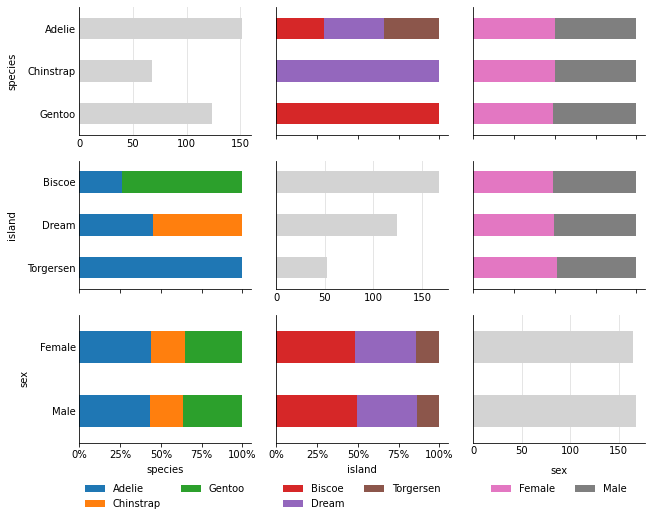

In [31]:
var_cat = [var for var in df if df[var].nunique() <= nb_unique_limit]
stackedbarmatrix(df[var_cat], nb_unique_limit)

# 5. Time series

In [32]:
def timegrid(df):
    """
    Create a time series plot of each numerical variables in the dataset.
    
    Parameters
    ----------
    df: pandas DataFrame
        DataFrame containing a time series.
    """
    
    ## Select variables to plot
    var_num = df.select_dtypes('number').columns
    if 'datetime' in str(type(df.index)):
        var_date = None
    else:
        var_date = df.select_dtypes('datetime').columns[0]
    
    ncharts = var_num.size
    
    ## Print statement for cases where this figure is not relevant
    if ncharts == 0:
        print(
'''There are no numerical variables in this dataset, so time series
plots for numerical variables are not relevant.
        ''')
    
    ## Create timegrid
    else:
        # Define figure dimensions parameters
        ncols_max = 3
        ncols = ncharts if ncharts < ncols_max else ncols_max
        nrows = int(np.ceil(ncharts/ncols))
        width = 7 if ncols <= 2 else 5 if ncols <= 3 else 15/ncols
        height = 0.75*width
        
        fig = plt.figure(figsize=(ncols*width, nrows*height))
        colormap = plt.cm.tab10.colors
        # Draw pandas scatterplots side-by-side
        for idx, var in enumerate(var_num):
            ax = fig.add_subplot(nrows, ncols, idx+1)
            df.plot(x=var_date, y=var, marker='.', ms=5, linestyle='', linewidth=1,
                    color=colormap[idx%len(colormap)], ax=ax)
            ax.set_xlabel(xlabel=var_date, labelpad=10)
            ax.set_ylabel(var)
            ax.legend().remove()
            if idx < ncols*nrows-ncols:
                ax.set_xlabel('')
                ax.set_xticklabels([])
        sns.despine()
        fig.subplots_adjust(hspace=0.1, wspace=0.3)

In [33]:
if df.select_dtypes('datetime').size == 0 and 'datetime' not in str(type(df.index)):
    print('There is no time series in this dataset')
else:
    timegrid(df)

There is no time series in this dataset
